In [3]:
!pip install lightgbm chemprop git+https://github.com/PatWalters/useful_rdkit_utils matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/PatWalters/useful_rdkit_utils to /tmp/pip-req-build-lccbyun6
  Running command git clone --filter=blob:none --quiet https://github.com/PatWalters/useful_rdkit_utils /tmp/pip-req-build-lccbyun6
  Resolved https://github.com/PatWalters/useful_rdkit_utils to commit 57dc95bf269033fda0bb47a96340486f24ce71be
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from rdkit import Chem
from rdkit.Chem import Descriptors
from tqdm.auto import tqdm
import warnings
from helper import scaffold_split

Enable Pandas progress apply

In [2]:
tqdm.pandas()

Read the data 

In [8]:
df = pd.read_csv("ADME_public_set_3521.csv")

In [9]:
df.describe()

,LOG HLM_CLint (mL/min/kg),LOG MDR1-MDCK ER (B-A/A-B),LOG SOLUBILITY PH 6.8 (ug/mL),LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound),LOG PLASMA PROTEIN BINDING (RAT) (% unbound),LOG RLM_CLint (mL/min/kg)
count,3087.000000,2642.000000,2173.000000,194.000000,168.000000,3054.000000
mean,1.320019,0.397829,1.259943,0.765722,0.764177,2.256207
std,0.623952,0.688465,0.683416,0.847902,0.798988,0.750422
min,0.675687,-1.162425,-1.000000,-1.593460,-1.638272,1.027920
25%,0.675687,-0.162356,1.153510,0.168067,0.226564,1.688291
50%,1.205313,0.153291,1.542825,0.867555,0.776427,2.311068
75%,1.803115,0.905013,1.687351,1.501953,1.375962,2.835274
max,3.372714,2.725057,2.179264,2.000000,2.000000,3.969622


Convert solublity to uM

In [10]:
def compute_mol_weight(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Descriptors.MolWt(mol)
df['Molecular Weight'] = df['SMILES'].apply(compute_mol_weight)
df['LOG SOLUBILITY PH 6.8 (uM)'] = ((10**df['LOG SOLUBILITY PH 6.8 (ug/mL)']) * 1000) / df['Molecular Weight']
df['LOG SOLUBILITY PH 6.8 (uM)'] = np.log10(df['LOG SOLUBILITY PH 6.8 (uM)'])

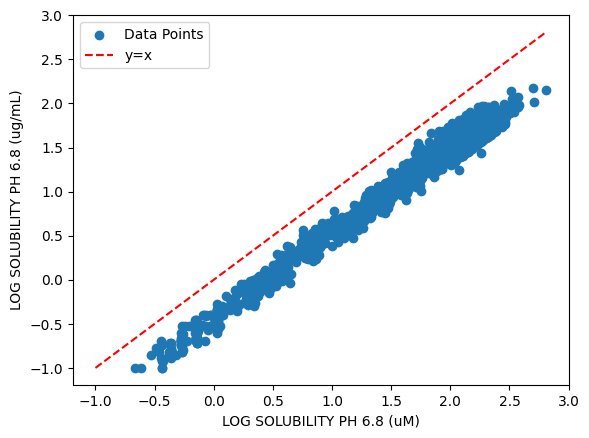

In [11]:
plt.scatter(df[ "LOG SOLUBILITY PH 6.8 (uM)"], df["LOG SOLUBILITY PH 6.8 (ug/mL)"], label='Data Points')
min_val = min(df[ "LOG SOLUBILITY PH 6.8 (uM)"].min(), df["LOG SOLUBILITY PH 6.8 (ug/mL)"].min())
max_val = max(df[ "LOG SOLUBILITY PH 6.8 (uM)"].max(), df["LOG SOLUBILITY PH 6.8 (ug/mL)"].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y=x')
plt.xlabel( "LOG SOLUBILITY PH 6.8 (uM)")
plt.ylabel("LOG SOLUBILITY PH 6.8 (ug/mL)")
plt.legend()
plt.show()

array([[<Axes: title={'center': 'LOG SOLUBILITY PH 6.8 (uM)'}>,
        <Axes: title={'center': 'LOG SOLUBILITY PH 6.8 (ug/mL)'}>]],
      dtype=object)

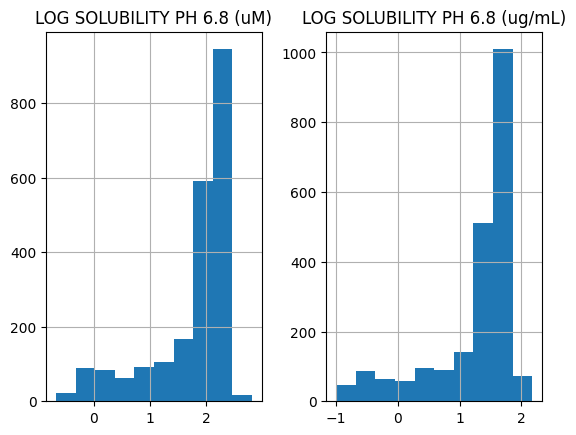

In [12]:
df[["LOG SOLUBILITY PH 6.8 (uM)", "LOG SOLUBILITY PH 6.8 (ug/mL)"]].hist()

Add an RDKit molecule to the dataframe.  

In [13]:
df = df.drop(['LOG SOLUBILITY PH 6.8 (ug/mL)', 'Molecular Weight'],axis=1)
df['mol'] = df.SMILES.progress_apply(Chem.MolFromSmiles)

  0%|          | 0/3521 [00:00<?, ?it/s]

Delete rows where the SMILES couldn't be parsed

In [14]:
df_ok = df.dropna(subset=['mol']).copy()

Make sure we don't have duplicate molecules

In [15]:
df_ok['cansmi'] = df_ok.mol.apply(Chem.MolToSmiles)

In [16]:
df_ok.cansmi.value_counts()

cansmi
CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H]3C[C@@H]3F)cnc12    1
Cc1nccc(NC(=O)CCc2ccncc2)c1Cl                                      1
CCc1nnc(N2CC(N(C)C)C2)c(C#N)c1CC                                   1
CCc1nnc(Nc2cc(C)nc(C3CN(C(=O)C(C)C)CCO3)c2)s1                      1
O=C(Nc1ccncc1)[C@H]1CCCN(S(=O)(=O)c2ccc(Cl)cc2)C1                  1
                                                                  ..
O=C(c1ccccn1)N1CCCC(c2cccc(-c3cccc(Cl)c3)n2)C1                     1
CN1CCN(c2ccc(NC(=O)c3ccc(S(=O)(=O)N4CCCc5ccccc54)cc3)cc2)CC1       1
Cc1cnn(Cc2nc(Cn3cccn3)no2)c1                                       1
COc1ccccc1CC(=O)Nc1ncc(C)s1                                        1
Cc1cccc(/C=N/Nc2cc(N3CCOCC3)n3nc(-c4ccncc4)cc3n2)c1                1
Name: count, Length: 3521, dtype: int64

Drop the molecule column

In [17]:
df_ok = df_ok.drop(["mol","cansmi"],axis=1)

Double check the sizes of the dataframes

In [18]:
len(df),len(df_ok),len(df)-len(df_ok)

(3521, 3521, 0)

Create two dataframes, one with the molecules that have Sol data and one with the molecules that don't. For single task, we'll only use the molecules with Sol data.  For multitask, we'll use all the data. 

In [19]:
rename_ls = ['Name',
 'Vendor ID',
 'SMILES',
 'CollectionName',
 'HLM_CLint',
 'ER',
 'HPPB',
 'RPPB',
 'RLM_CLint',
 'Sol']
rename_dic = dict(zip(df_ok.columns.tolist(), rename_ls))
rename_dic

{'Internal ID': 'Name',
 'Vendor ID': 'Vendor ID',
 'SMILES': 'SMILES',
 'CollectionName': 'CollectionName',
 'LOG HLM_CLint (mL/min/kg)': 'HLM_CLint',
 'LOG MDR1-MDCK ER (B-A/A-B)': 'ER',
 'LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)': 'HPPB',
 'LOG PLASMA PROTEIN BINDING (RAT) (% unbound)': 'RPPB',
 'LOG RLM_CLint (mL/min/kg)': 'RLM_CLint',
 'LOG SOLUBILITY PH 6.8 (uM)': 'Sol'}

In [20]:
df_ok = df_ok.rename(columns=rename_dic)

array([[<Axes: title={'center': 'HLM_CLint'}>,
        <Axes: title={'center': 'ER'}>],
       [<Axes: title={'center': 'HPPB'}>,
        <Axes: title={'center': 'RPPB'}>],
       [<Axes: title={'center': 'RLM_CLint'}>,
        <Axes: title={'center': 'Sol'}>]], dtype=object)

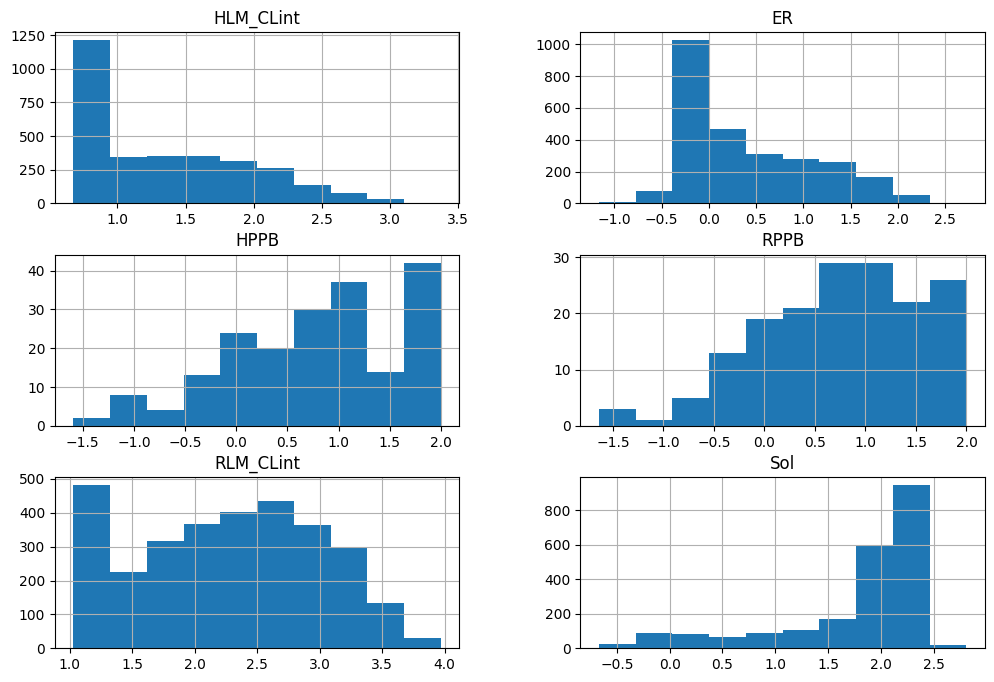

In [21]:
df_ok.hist(figsize = (12, 8))

In [22]:
df_sol = df_ok.dropna(subset=["Sol"]).copy()
df_rest = df_ok[df_ok.Sol.isna()].copy()

In [23]:
df_rest

,Name,Vendor ID,SMILES,CollectionName,HLM_CLint,ER,HPPB,RPPB,RLM_CLint,Sol
2,Mol3,304005766,CN(c1ncc(F)cn1)[C@H]1CCCNC1,emolecules,0.675687,-0.358806,2.000000,2.000000,1.027920,NaN
4,Mol5,324059015,CC(C)(O)CCn1cc2cc(NC(=O)c3cccc(C(F)(F)F)n3)c(C...,emolecules,0.996380,1.010597,1.015611,1.092264,1.629093,NaN
6,Mol7,299985775,CC(C)NCC(O)COc1cccc2ccccc12,emolecules,1.327232,-0.162401,NaN,1.347759,3.318276,NaN
7,Mol8,538570,COc1ccc(Cl)cc1C(=O)NCCc1ccc(S(=O)(=O)NC(=O)NC2...,emolecules,1.458063,2.091561,-0.917215,-0.943095,2.728062,NaN
9,Mol10,44811418,CC(C)NC(=O)COc1cccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3...,emolecules,1.630824,1.301829,-1.384078,-0.504456,3.192741,NaN
...,...,...,...,...,...,...,...,...,...,...
3516,Mol3517,43258693,O=C(c1ccc2c(c1)CCCC2)N1CCOCC1c1ccn[nH]1,emolecules,NaN,0.606813,NaN,NaN,NaN,NaN
3517,Mol3518,27448206,O=C(Nc1nc2ccccc2[nH]1)c1ccc(-n2cccc2)cc1,emolecules,NaN,-0.444495,NaN,NaN,NaN,NaN
3518,Mol3519,207150215,NC(=O)c1noc([C@@H](CCCC2CCCCC2)CC(=O)NO)n1,emolecules,0.863799,NaN,NaN,NaN,NaN,NaN
3519,Mol3520,25037224,CCCCCCCCc1ccc(CC[C@](N)(CO)COP(=O)(O)O)cc1,emolecules,0.881385,NaN,NaN,NaN,NaN,NaN


There are some sizeable series, so go ahead with scaffold split

In [24]:
from helper import scaffold_to_smiles

scaffold_to_indices = scaffold_to_smiles(df_ok.SMILES, use_indices=True)
counts = {key: len(value) for key, value in scaffold_to_indices.items()}
df = pd.DataFrame(counts.items(), columns=['Item', 'Count'])
df_sorted = df.sort_values(by='Count', ascending=False).reset_index(drop=True)
df_sorted.head(20)

,Item,Count
0,c1ccccc1,50
1,c1ccc2ncccc2c1,16
2,c1ccncc1,16
3,c1ccc(-n2cccn2)cc1,12
4,O=C(CN1CCCN(c2ccccn2)CC1)Nc1ccccc1,10
5,c1ccc(-c2cscn2)cc1,10
6,c1cn[nH]c1,10
7,c1ccc2[nH]cnc2c1,8
8,c1ccc2[nH]ccc2c1,8
9,O=S(=O)(Nc1ccccc1)c1ccccc1,8


Write the splits to disk. Supress warnings because we're writing floats and NAs in a column. 

In [25]:
df_sol.to_csv("sol_processed.csv", index=False)

In [29]:
import os
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from tqdm import tqdm
import warnings

import useful_rdkit_utils as uru

In [30]:
n_outer = 5; n_inner = 5; y_col = "Sol"

In [31]:
group_list = [("random", uru.get_random_split),
            ("scaffold", uru.get_bemis_murcko_clusters)]

In [32]:
base_name = "data/Sol_repeated"

df_sol['Sol_bins'] = pd.cut(df_sol['Sol'], bins=10, labels=False)
df = df_sol.copy()
metric_vals = []
fold_df_list = []
input_cols = df.columns
for i in tqdm(range(0, n_outer), leave=False):
    kf = uru.GroupKFoldShuffle(n_splits=n_inner, shuffle=True)
    for group_name, group_func in group_list:
        # assign groups based on cluster, scaffold, etc
        prefix = f"{group_name}"
        current_group = group_func(df.SMILES)
        for j, [train_idx, test_idx] in enumerate(
                tqdm(kf.split(df, groups=current_group), total=n_inner, leave=False)):
            fold = i * n_outer + j

            dir_name = f"{base_name}{fold:03d}"
            if not os.path.exists(dir_name):
                os.mkdir(dir_name)
            
            train = df.iloc[train_idx].copy()
            test = df.iloc[test_idx].copy()

            train['dset'] = 'train'
            test['dset'] = 'test'
            train['group'] = group_name
            test['group'] = group_name
            train['fold'] = fold
            test['fold'] = fold

            train, val = train_test_split(train, test_size=0.1, stratify=train['Sol_bins'], random_state=fold)

            # if group_name == 'random':
            #     train, val = train_test_split(train, test_size=0.1, stratify=train['Sol_bins'], random_state=fold)
            # else:
            #     scaf_train, scaf_val = scaffold_split(train.SMILES, sizes=(0.9, 0.1), seed=fold)
            #     val = train.iloc[scaf_val]
            #     train = train.iloc[scaf_train]

            st_cols = ["SMILES", "Name", "Sol"]
            train[st_cols].to_csv(f"{dir_name}/{prefix}_train_{fold:03d}.csv", index=False)
            val[st_cols].to_csv(f"{dir_name}/{prefix}_val_{fold:03d}.csv", index=False)
            test[st_cols].to_csv(f"{dir_name}/{prefix}_test_{fold:03d}.csv", index=False)

            mt_cols = ["SMILES", "Name", "Sol", "HLM_CLint", "RLM_CLint", "ER", "HPPB", "RPPB"]
            # rest_train, rest_val = train_test_split(df_rest, test_size=0.2, random_state=fold)
            # train = pd.concat([train, rest_train]).sample(frac=1.0)
            train[mt_cols].to_csv(f"{dir_name}/{prefix}_mt_train_{fold:03d}.csv", index=False)
            # val = pd.concat([val, rest_val]).sample(frac=1.0)
            val[mt_cols].to_csv(f"{dir_name}/{prefix}_mt_val_{fold:03d}.csv", index=False)
            test[mt_cols].to_csv(f"{dir_name}/{prefix}_mt_test_{fold:03d}.csv", index=False)

            fold_df_list.append(pd.concat([train, test]))
output_cols = list(input_cols) + ['dset','group','fold']
pd.concat(fold_df_list)[output_cols].to_csv(f"{y_col}_folds_multitask.csv", index=False)

100%|██████████| 5/5 [00:00<00:00, 45.67it/s]
                                             
100%|██████████| 5/5 [00:00<00:00, 47.17it/s]
                                             
100%|██████████| 5/5 [00:00<00:00, 46.63it/s]
                                             
100%|██████████| 5/5 [00:00<00:00, 46.94it/s]
                                             
100%|██████████| 5/5 [00:00<00:00, 46.70it/s]
                                             
100%|██████████| 5/5 [00:00<00:00, 47.33it/s]
